# [E-10] news_summarization

데이터: [sunnysai12345/News_Summary](https://github.com/sunnysai12345/News_Summary)

## 1. 모듈 & 데이터 가져오기

In [4]:
# NLTK 패키지에서 불용어 사전을 다운로드
# 데이터 전처리를 위한 패키지 불러오기
import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [4]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [5]:
data.sample(10)

,headlines,text
927,UP man gets 7 years in jail for abetting wife'...,A fast track court in Muzaffarnagar has senten...
89452,UP govt refuses trial for CM Yogi in Gorakhpur...,The UP government on Thursday denied permissio...
46812,Diljit mentions celebrity crush Kylie in new s...,Singer Diljit Dosanjh has mentioned his celebr...
11379,Picture of Jennifer Lopez posing in just a cap...,A picture of singer Jennifer Lopez posing in j...
41093,Journos guilty of writing fake news could lose...,The Information and Broadcasting Ministry has ...
25044,Kangana's 'Manikarnika' to clash with Hrithik'...,The release date of Kangana Ranaut starrer 'Ma...
37036,Tamil Nadu becoming breeding ground for extrem...,BJP MP Pon Radhakrishnan has claimed that Tami...
87809,Suspected Manchester bomber identified as Salm...,UK Police on Tuesday named 22-year-old Salman ...
11186,Amnesty renames road outside Saudi embassy aft...,Activists of human rights organisation Amnesty...
50447,SRH retain Rashid for Ã¢ÂÂ¹9cr after buying h...,"Nineteen-year-old Afghan spinner Rashid Khan, ..."


---

## 2. 데이터 전처리

1. 빈칸으로 존재하는 null 데이터

2. 의미는 같지만 다른 식으로 작성된 글 같은 중복 항목

In [5]:
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98401


In [6]:
# 데이터의 중복 샘플 유무를 확인
print('text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())
print('headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())

text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280


In [7]:
# text가 달라도 headlines는 동일할 수 있다.
# 하지만 text 자체가 중복이 된 경우는 중복 샘플이므로 제거
# 데이터프레임의 drop_duplicates()를 사용

# inplace=True 를 설정하면 DataFrame 타입 값을 return 하지 않고 
# data 내부를 직접적으로 바꿉니다
data.drop_duplicates(subset = ['text'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


In [8]:
# Null 값이 남아있는지 확인 
# .isnull().sum()을 사용

print(data.isnull().sum())

headlines    0
text         0
dtype: int64


### 텍스트 정규화, 불용어 제거

In [9]:
# 텍스트 정규화(text normalization) 
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


In [10]:
# 불용어(stopwords)
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

In [11]:
# 전처리 전 데이터의 일부 내용 확인해보기
print(data['text'][0])
print(data['text'][1])

Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers.
Kunal Shah's credit card bill payment platform, CRED, gave users a chance to win free food from Swiggy for one year. Pranav Kaushik, a Delhi techie, bagged this reward after spending 2000 CRED coins. Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more.


In [12]:
# 모든 영어 문자는 소문자로 만들고, 
# 섞여있는 html 태그를 제거하고, 
# 정규 표현식을 통해 각종 특수문자를 제거

# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (headlines)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [13]:
# 전처리 전, 후의 결과를 확인하기 위해서 임의의 text와 headlines를 만들어 함수를 호출
temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_headlines = 'Great way to start (or finish) the day!!!'

print(preprocess_sentence(temp_text))
print(preprocess_sentence(temp_headlines, False))  # 불용어를 제거하지 않습니다.

everything bought great infact ordered twice third ordered wasfor mother father
great way to start the day


In [14]:
# 멀티프로세싱을 사용해보자.

import multiprocessing as mp   # 멀티 프로세싱으로 전처리 속도를 획기적으로 줄여봅시다
from multiprocessing import Pool
import numpy as np
import time
from functools import partial  # map을 할 때 함수에 여러 인자를 넣어줄 수 있도록 합니다

start = time.time()

# num_cores 만큼 쪼개진 데이터를 전처리하여 반환합니다
def appendTexts(sentences, remove_stopwords):
  texts = []
  for s in sentences:
    texts += preprocess_sentence(s, remove_stopwords),
  return texts

def preprocess_data(data, remove_stopwords=True):
  start_time = time.time()
  num_cores = mp.cpu_count()  # 컴퓨터의 코어 수를 구합니다

  text_data_split = np.array_split(data, num_cores)  # 코어 수만큼 데이터를 배분하여 병렬적으로 처리할 수 있게 합니다
  pool = Pool(num_cores)

  processed_data = np.concatenate(pool.map(partial(appendTexts, remove_stopwords=remove_stopwords), text_data_split))  # 각자 작업한 데이터를 하나로 합쳐줍니다
  pool.close()
  pool.join()
  print(time.time() - start_time, " seconds")
  return processed_data

clean_text = preprocess_data(data['text'])  
print(clean_text)

clean_headlines = preprocess_data(data['headlines'], remove_stopwords=False) 
print(clean_headlines)

426.032639503479  seconds
['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers'
 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit'
 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history'
 ...
 'according reports new version science fiction film matrix development michael jordan reportedly play lead role film screenwriter zak p

In [15]:
# 정제 과정에서 단어가 사라지는 경우가 있기 때문에 빈값을 한 번더 확인 한다.
# 빈 값들은 모두 Null 값으로 변환
data['text'] = clean_text
data['headlines'] = clean_headlines

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)

In [16]:
# Null값이 잘 들어갔는지 확인
data.isnull().sum()

headlines    0
text         0
dtype: int64

In [17]:
# 빈 샘플 삭제
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


---

### 훈련 데이터와 테스트 데이터 나누기

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
요약의 최소 길이 : 1
요약의 최대 길이 : 16
요약의 평균 길이 : 9.299532330215534


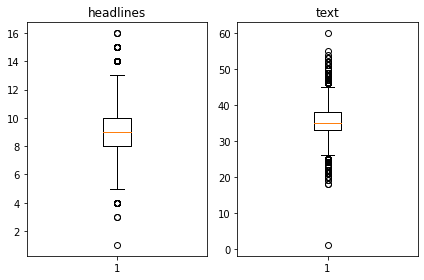

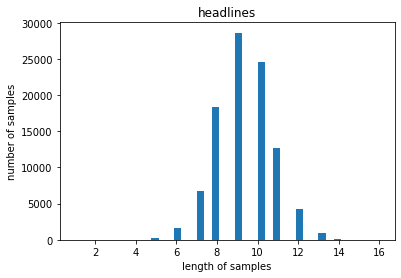

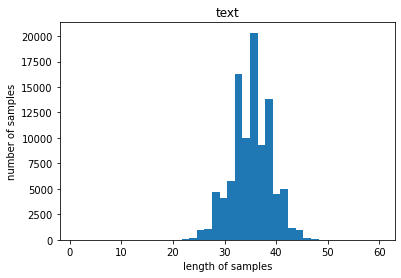

In [19]:
# 훈련에 사용할 샘플의 최대 길이 설정하기
# Text와  headlines의 최소, 최대, 평균 길이를 구하고 또한 길이 분포를 시각화

# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
headlines_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(headlines_len)))
print('요약의 최대 길이 : {}'.format(np.max(headlines_len)))
print('요약의 평균 길이 : {}'.format(np.mean(headlines_len)))

plt.subplot(1,2,1)
plt.boxplot(headlines_len)
plt.title('headlines')
plt.subplot(1,2,2)
plt.boxplot(text_len)
plt.title('text')
plt.tight_layout()
plt.show()

plt.title('headlines')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [39]:
# 임의로 최대 길이 지정
text_max_len = 50
headlines_max_len = 12

In [40]:
# 훈련 데이터와 샘플의 길이를 입력하면, 
# 데이터의 몇 %가 해당하는지 계산하는 함수

def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [41]:
below_threshold_len(text_max_len, data['text'])
below_threshold_len(headlines_max_len,  data['headlines'])

전체 샘플 중 길이가 50 이하인 샘플의 비율: 1.0
전체 샘플 중 길이가 12 이하인 샘플의 비율: 1.0


In [42]:
# 정해진 길이보다 길면 제외하도록 샘플 정제
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['headlines'].apply(lambda x: len(x.split()) <= headlines_max_len)]
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 97169


### 시작 토큰, 종료토큰 추가

- 시작 토큰은 sostoken, 종료 토큰은 eostoken이라 임의로 명명

- decoder_input: 디코더의 입력에 해당하면서 시작 토큰이 맨 앞에 있는 문장

- decoder_target: 디코더의 출력 또는 레이블에 해당되면서 종료 토큰이 맨 뒤에 붙는 문장



In [43]:
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
1,delhi techie wins free food from swiggy for on...,kunal shah credit card bill payment platform c...,sostoken delhi techie wins free food from swig...,delhi techie wins free food from swiggy for on...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
5,rahat fateh ali khan denies getting notice for...,pakistani singer rahat fateh ali khan denied r...,sostoken rahat fateh ali khan denies getting n...,rahat fateh ali khan denies getting notice for...


In [44]:
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

In [45]:
# encoder_input과 크기와 형태가 같은 순서가 섞인 정수 시퀀스 생성
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[32180 67531 47635 ... 12129 30482 26783]


In [46]:
# 정수 시퀀스를 이용해 데이터의 샘플 순서 정의

encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [47]:
# 섞인 데이터를 8:2의 비율로 훈련 데이터와 테스트 데이터로 분리
# 테스트 데이터의 크기 정의
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 19433


In [48]:
# 전체 데이터 양분
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 77736
훈련 레이블의 개수 : 77736
테스트 데이터의 개수 : 19433
테스트 레이블의 개수 : 19433


In [49]:
# 데이터의 단어들을 모두 정수로 바꾸기
# 각 단어에 고유한 정수를 맵핑하는 작업이 필요 - 단어 집합(vocabulary) 을 만든다
# 훈련 데이터의 단어집합
# Keras의 토크나이저를 사용

src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

In [50]:
# 등장 빈도수가 7회 미만인 단어들이 이 데이터에서 얼만큼의 비중을 차지하는지 확인
# src_tokenizer.word_counts.items(): 단어와 각 단어의 등장 빈도수 저장

threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 69275
등장 빈도가 6번 이하인 희귀 단어의 수: 47234
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 22041
단어 집합에서 희귀 단어의 비율: 68.18332731865753
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.515720070727123


In [51]:
# 토크나이저를 정의할 때 num_words의 값을 정해주면, 단어 집합의 크기를 제한
src_vocab = 22000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 22000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성.

In [52]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[302, 77, 860, 742, 921, 4093, 25, 2510, 241, 351, 171, 3960, 3, 1228, 152, 234, 2510, 648, 860, 1208, 5302, 1797, 748, 2510, 186, 219, 921, 21, 8, 331, 143, 5475, 2510, 21], [2692, 563, 595, 3054, 1848, 4160, 1074, 224, 217, 217, 660, 104, 3054, 1, 463, 618, 2403, 1681, 5643, 1755, 337, 6, 582, 11217, 5055, 66, 1849, 163], [1646, 1554, 2432, 200, 4022, 1448, 382, 1675, 5944, 1933, 274, 3037, 1448, 382, 976, 50, 200, 1520, 382, 14716, 5886, 3141, 674, 3670, 67, 19, 1554, 1]]


In [53]:
# decoder_input_train을 입력으로 전체 단어 집합과 각 단어에 대한 빈도수를 계산

tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [54]:
# 등장 빈도수가 6회 미만인 단어들이 이 데이터에서 얼만큼의 비중을 차지하는지 확인
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 29932
등장 빈도가 5번 이하인 희귀 단어의 수: 19570
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 10362
단어 집합에서 희귀 단어의 비율: 65.38153147133502
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.707876318354658


In [55]:
# 비중이 상대적으로 적은 빈도수가 5이하인 단어들 제거
# 어림잡아 10,000을 단어 집합의 크기로 제한

tar_vocab = 10000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 55, 799, 696, 39, 2254], [1, 1988, 1117, 3, 3011, 9488, 310, 5], [1, 1460, 839, 196, 144, 3, 8754, 1823, 159, 3648], [1, 346, 20, 42, 480, 4246, 3, 1491, 1707], [1, 6789, 261, 449, 1852, 355, 5, 756, 3227]]
target
decoder  [[55, 799, 696, 39, 2254, 2], [1988, 1117, 3, 3011, 9488, 310, 5, 2], [1460, 839, 196, 144, 3, 8754, 1823, 159, 3648, 2], [346, 20, 42, 480, 4246, 3, 1491, 1707, 2], [6789, 261, 449, 1852, 355, 5, 756, 3227, 2]]


In [56]:
# 요약문에서 길이가 0이 된 샘플들의 인덱스 확인

drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = np.delete(encoder_input_train, drop_train, axis=0)
decoder_input_train = np.delete(decoder_input_train, drop_train, axis=0)
decoder_target_train = np.delete(decoder_target_train, drop_train, axis=0)

encoder_input_test = np.delete(encoder_input_test, drop_test, axis=0)
decoder_input_test = np.delete(decoder_input_test, drop_test, axis=0)
decoder_target_test = np.delete(decoder_target_test, drop_test, axis=0)

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 0


/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


훈련 데이터의 개수 : 77736
훈련 레이블의 개수 : 77736
테스트 데이터의 개수 : 19433
테스트 레이블의 개수 : 19433


In [57]:
# 정해두었던 최대 길이로 패딩

encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=headlines_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=headlines_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=headlines_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=headlines_max_len, padding='post')

## 3. 모델 설계

In [38]:
# 함수형 API를 이용해서 인코더를 설계

from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128 # 임베딩 벡터 차원 정의
hidden_size = 256 # hidden state: LSTM에서 얼만큼 수용력을 가질지를 정하는 파라미터

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

In [39]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

# 디코더는 LSTM의 입력을 정의할 때 initial state의 인자값으로 
# 인코더의 hidden state와 cell state의 값을 넣어줘야 함

In [40]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 50, 128)      2816000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 50, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

## 4. 어텐션 메커니즘 적용

어텐션 함수를 설계하는 것은 또 다른 새로운 신경망을 설계해야 한다

In [41]:
# 깃허브에 공개된 어텐션 함수 다운로드

urllib.request.urlretrieve("https://raw.githubusercontent.com/thushv89/attention_keras/master/src/layers/attention.py", filename="attention.py")
from attention import AttentionLayer

In [42]:
# 설계한 디코더의 출력층을 수정

# 어텐션 층(어텐션 함수)
attn_layer = AttentionLayer(name='attention_layer')
# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 50, 128)      2816000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 50, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

### 모델 훈련

EarlyStopping: 특정 조건이 충족되면 훈련을 멈추는 역할

In [43]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
304/304 [==============================] - 637s 2s/step - loss: 6.0015 - val_loss: 5.1632
Epoch 2/50
304/304 [==============================] - 604s 2s/step - loss: 5.0949 - val_loss: 4.7822
Epoch 3/50
304/304 [==============================] - 499s 2s/step - loss: 4.7244 - val_loss: 4.5335
Epoch 4/50
304/304 [==============================] - 268s 880ms/step - loss: 4.4446 - val_loss: 4.3353
Epoch 5/50
304/304 [==============================] - 263s 864ms/step - loss: 4.2285 - val_loss: 4.1931
Epoch 6/50
304/304 [==============================] - 262s 863ms/step - loss: 4.0533 - val_loss: 4.0696
Epoch 7/50
304/304 [==============================] - 262s 861ms/step - loss: 3.8956 - val_loss: 3.9752
Epoch 8/50
304/304 [==============================] - 264s 868ms/step - loss: 3.7517 - val_loss: 3.9095
Epoch 9/50
304/304 [==============================] - 267s 880ms/step - loss: 3.6380 - val_loss: 3.8436
Epoch 10/50
304/304 [==============================] - 261s 860ms/step - 

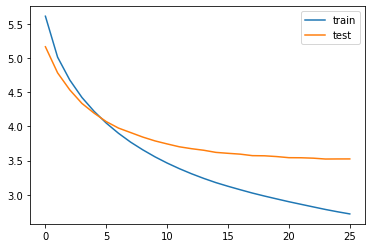

In [44]:
# 훈련 데이터의 손실과 검증 데이터의 손실이 줄어드는 과정을 시각화

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

### 인퍼런스 모델 구현

In [45]:
# 정수 인덱스 행렬로 존재하던 텍스트 데이터를 실제 데이터로 복원
# 필요한 3개의 사전을 미리 준비

src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

In [46]:
# seq2seq는 훈련할 때와 실제 동작할 때(인퍼런스 단계)의 방식이 다르므로 
#그에 맞게 모델 설계를 별개로 진행해야 한다
# 인퍼런스 단계에서는 만들어야 할 문장의 길이만큼 디코더가 반복 구조로 동작
# 인퍼런스를 위한 모델 설계를 별도로 해주어야 함
# 인코더 모델과 디코더 모델을 분리해서 설계


# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [47]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [48]:
# 인퍼런스 단계에서 단어 시퀀스를 완성하는 함수

def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headlines_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

## 5. 실제 결과와 요약문 비교 (추상적 요약)

In [2]:
# 정수 시퀀스를 텍스트 시퀀스로 변환하는 함수
# Text의 정수 시퀀스에서는 패딩을 위해 사용되는 숫자 0을 제외
# headlines의 정수 시퀀스에서는 
# 숫자 0, 시작 토큰의 인덱스, 종료 토큰의 인덱스를 출력에서 제외

# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

In [50]:
text_list = []
target_sum = []


for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : tripura government decided introduce reservation women levels police department initially start reservation fight crime women may hike later depending feedback state law minister ratan lal nath said state government also made written test mandatory recruitment ensure transparency 
실제 요약 : tripura govt reserves posts in police force for women 
예측 요약 :  tripura govt withdraws reservation for women in telangana


원문 : us secretary state mike pompeo said country rejects russia annexation crimea russian foreign ministry said us fails stick commitments citing us withdrawal iran nuclear deal paris climate agreement ministry added us foreign policy changes change leadership 
실제 요약 : us fails to stick to russian foreign ministry 
예측 요약 :  russia cannot be ready for us russia


원문 : indian shuttler kidambi srikanth knocked contention season ending bwf world tour finals eighth seed beat straight games quarter finals hong kong open friday year old shuttler four superseries titles registered s

예측 요약 :  father kills self son for son found in delhi


원문 : essar group monday said repaid lakh crore debt past two years group debt group holding company essar global holdings repaid last debt crore various banks continuing lender essar global russia group 
실제 요약 : essar group more than of its total debt in years 
예측 요약 :  essar bank to invest cr in debt for fy


원문 : claiming mahagathbandhan failed idea prime minister narendra modi wednesday said parties constantly come together opportunity form government added us winning election defeating rivals serving people 
실제 요약 : first parties fight then try to form govt pm on grand alliance 
예측 요약 :  pm modi is not to make world pm modi


원문 : fake town new york invented stop people map however another included place map observed general store actually built exact place located company maps 
실제 요약 : an town was once turned into real place 
예측 요약 :  fake news of china spy on fake news


원문 : united nations investigators wednesday found mass

예측 요약 :  class student scores in class exam in pakistan


원문 : premier league playoff would held liverpool arsenal manchester city finish identical results city liverpool would play third city draw liverpool win arsenal draw liverpool lose two play fourth city arsenal playoff likely city lose arsenal win 
실제 요약 : what happens if liverpool arsenal city finish 
예측 요약 :  man city win man utd win streak with pl win


원문 : retired year old japanese banker created gaming app based japanese doll festival oldest person attend apple worldwide developers conference year started using computer age took online coding apple annual conference showcases new software technologies 
실제 요약 : yr old woman app maker oldest to attend apple conference 
예측 요약 :  ex nasa year old becomes world largest smartphone


원문 : csk rounder dwayne bravo pulled diving catch dismiss srh yusuf pathan runs bowling ipl qualifier tuesday year old dived low follow reacted time pluck catch jumping regain control bravo picked tw

- 요약 결과가 그리 좋지 못한 것 같다.
- 어느 정도 유사하게 요약한 경우가 있긴하지만 대부분이 요약을 잘 하지 못하는 것 같다.
- 특히나 동어 반복 문제가 좀 있는 것 같다.

<br><br>

### 유사도 확인: Sentence Transformers 패키지 활용

- 문장 하나하나 50개를 주관적으로 비교하는 것이 불편하여 다르게 비교 할 수 있는 방법을 고민해 보았다.

- 그러던 중 문장간 유사도를 확인해보면 어떨까 생각이 들어 서치해보았고, 간단하게 사전 훈련된 모델을 사용할 수 있는 `Sentence-Transformers' 패키지를 활용해보았다.

- 해당 패키지를 통해 BERT, RoBERTa, XLM-RoBERTa 등의 알고리즘을 사용할 수 있고, 100개 이상의 언어에 대해 사전 훈련된 모델도 이용 가능

- 위 결과를 별도 csv 파일로 따로 추출해서 불러왔다.



In [5]:
sum_data = pd.read_csv('~/aiffel/news_summarization/data/summarization.csv')
sum_data.head()

,text,target,prediction
0,tripura government decided introduce reservati...,tripura govt reserves posts in police force fo...,tripura govt withdraws reservation for women i...
1,us secretary state mike pompeo said country re...,us fails to stick to russian foreign ministry,russia cannot be ready for us russia
2,indian shuttler kidambi srikanth knocked conte...,srikanth out of world tour finals after loss,srikanth beats srikanth to reach world no supe...
3,maharashtra cm devendra fadnavis monday said ...,maneka used harsh words will probe tigress de...,maha cm blames maha cm for killing those who k...
4,info edge parent company real estate website a...,owner of invests in health tech startup,acquires hyderabad based app for crore


- sentence-transformers 패키지 설치 및 불러오기

In [6]:
pip install -U sentence-transformers

     |████████████████████████████████| 78 kB 3.9 MB/s eta 0:00:011
     |████████████████████████████████| 3.3 MB 10.0 MB/s eta 0:00:01
     |████████████████████████████████| 3.1 MB 42.8 MB/s eta 0:00:01
     |████████████████████████████████| 59 kB 14.0 MB/s eta 0:00:01
     |████████████████████████████████| 40 kB 12.3 MB/s eta 0:00:01
  Created wheel for sentence-transformers: filename=sentence_transformers-2.1.0-py3-none-any.whl size=120999 sha256=de838cc6b504b6222b647ce90701a5d65102a4896117f313936e2c881b3b9f59
  Stored in directory: /aiffel/.cache/pip/wheels/90/f0/bb/ed1add84da70092ea526466eadc2bfb197c4bcb8d4fa5f7bad
Successfully built sentence-transformers
  Attempting uninstall: packaging
    Found existing installation: packaging 20.8
    Uninstalling packaging-20.8:
      Successfully uninstalled packaging-20.8
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.9.4
    Uninstalling tokenizers-0.9.4:
      Successfully uninstalled tokenizers-0.9.

In [7]:
from sentence_transformers import SentenceTransformer, util
model = SentenceTransformer('paraphrase-distilroberta-base-v1') # 사용할 모델

Downloading:   0%|          | 0.00/391 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.74k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/718 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/329M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.35k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/798k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [8]:
target_list = sum_data['target'].to_list()
pred_list = sum_data['prediction'].to_list()

In [9]:
embedding1 = model.encode(target_list, convert_to_tensor=True)
embedding2 = model.encode(pred_list, convert_to_tensor=True)

In [10]:
cosine_scores = util.pytorch_cos_sim(embedding1, embedding2)

In [46]:
for i, idx in enumerate(cosine_scores):
    print(f"{i+1}. \n실제 요약:{target_list[i]} \n예측 요약:{pred_list[i]} \nScore: {cosine_scores[i][i]:4f}")
    print("="*50)

1. 
실제 요약:tripura govt reserves posts in police force for women 
예측 요약:tripura govt withdraws reservation for women in telangana 
Score: 0.685911
2. 
실제 요약:us fails to stick to russian foreign ministry 
예측 요약:russia cannot be ready for us russia 
Score: 0.306064
3. 
실제 요약:srikanth out of world tour finals after loss  
예측 요약:srikanth beats srikanth to reach world no superseries finals 
Score: 0.638735
4. 
실제 요약: maneka used harsh words will probe tigress death maha cm 
예측 요약:maha cm blames maha cm for killing those who killed self 
Score: 0.343844
5. 
실제 요약:owner of invests in health tech startup  
예측 요약:acquires hyderabad based app for crore 
Score: 0.224301
6. 
실제 요약:white house considering indra nooyi to head world bank reports 
예측 요약:ex us president nooyi replaces ex head of head 
Score: 0.379884
7. 
실제 요약:paid for porn using cryptocurrency admits mcafee  
예측 요약:mcafee mcafee calls for cryptocurrency trading 
Score: 0.636056
8. 
실제 요약:lakh indians forced to leave their homes in repo

- 위 유사도를 보니 스코어가 50%를 넘는 경우가 50개 중 14개밖에 되질 않는다.
- 확실히 요약이 잘 안된 것을 직관적으로 확인할 수 있다.

## 6. 추출적 요약 

패키지 Summa에서는 추출적 요약을 위한 모듈인 summarize를 제공

In [51]:
! pip list | grep summa

summa                         1.2.0
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [42]:
import requests
from summa.summarizer import summarize

In [43]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data2 = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [44]:
print(data2[:1500])

                                              headlines  \
0     upGrad learner switches to career in ML & Al w...   
1     Delhi techie wins free food from Swiggy for on...   
2     New Zealand end Rohit Sharma-led India's 12-ma...   
3     Aegon life iTerm insurance plan helps customer...   
4     Have known Hirani for yrs, what if MeToo claim...   
...                                                 ...   
1495  Have seen Sachin Tendulkar get angry but not M...   
1496  Player ensures wife stays dry in rain during A...   
1497  Federer denied entry into locker room by secur...   
1498  42/42 seats in West Bengal: CM Mamata's cutout...   
1499  Court refuses chargesheet by Delhi Police agai...   

                                                   text  
0     Saurav Kant, an alumnus of upGrad and IIIT-B's...  
1     Kunal Shah's credit card bill payment platform...  
2     New Zealand defeated India by 8 wickets in the...  
3     With Aegon Life iTerm Insurance plan, customer...  
4

### summarize 사용하기

- Summa의 summarize()의 인자
    
    - text (str) : 요약할 테스트.
    - ratio (float, optional) – 요약문에서 원본에서 선택되는 문장 비율. 0~1 사이값
    - words (int or None, optional) – 출력에 포함할 단어 수.
    - 만약, ratio와 함께 두 파라미터가 모두 제공되는 경우 ratio는 무시한다.
    - split (bool, optional) – True면 문장 list / False는 조인(join)된 문자열을 반환
    
- Summa의 summarize는 내부적으로 문장 토큰화를 수행 
- 원문을 바로 입력


In [45]:
for i in range(10):
    print("실제 요약 : ", data2['headlines'][i])
    print("예측 요약 : ", summarize(data2['text'][i], ratio=0.5))
    print("\n")

실제 요약 :  upGrad learner switches to career in ML & Al with 90% salary hike
예측 요약 :  upGrad's Online Power Learning has powered 3 lakh+ careers.


실제 요약 :  Delhi techie wins free food from Swiggy for one year on CRED
예측 요약 :  Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more.


실제 요약 :  New Zealand end Rohit Sharma-led India's 12-match winning streak
예측 요약 :  The match witnessed India getting all out for 92, their seventh lowest total in ODI cricket history.


실제 요약 :  Aegon life iTerm insurance plan helps customers save tax
예측 요약 :  Also, customers have options to insure against Critical Illnesses, Disability and Accidental Death Benefit Rider with a life cover up to the age of 80 years.


실제 요약 :  Have known Hirani for yrs, what if MeToo claims are not true: Sonam
예측 요약 :  Speaking about the sexual harassment allegations against Rajkumar Hirani, Sonam Kapoor said, "I've known Hirani for ma

### 유사도 확인: Sentence Transformers 패키지 활용

- 마찬가지로 문장간 유사도를 확인하기 위해 sentence transformers 패키지를 활용하였다.

- 위 결과를 별도 csv 파일로 따로 추출해서 불러왔다.

In [47]:
sum_data2 = pd.read_csv('~/aiffel/news_summarization/data/summarization2.csv')
sum_data2.head()

,target,prediction
0,upGrad learner switches to career in ML & Al w...,upGrad's Online Power Learning has powered 3 l...
1,Delhi techie wins free food from Swiggy for on...,Users get one CRED coin per rupee of bill paid...
2,New Zealand end Rohit Sharma-led India's 12-ma...,The match witnessed India getting all out for ...
3,Aegon life iTerm insurance plan helps customer...,"Also, customers have options to insure against..."
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...


In [48]:
model = SentenceTransformer('paraphrase-distilroberta-base-v1')
target_list2 = sum_data2['target'].to_list()
pred_list2 = sum_data2['prediction'].to_list()
embedding3 = model.encode(target_list2, convert_to_tensor=True)
embedding4 = model.encode(pred_list2, convert_to_tensor=True)
cosine_scores2 = util.pytorch_cos_sim(embedding3, embedding4)

In [49]:
for i, idx in enumerate(cosine_scores2):
    print(f"{i+1}. \n실제 요약:{target_list2[i]} \n예측 요약:{pred_list2[i]} \nScore: {cosine_scores2[i][i]:4f}")
    print("="*50)

1. 
실제 요약:upGrad learner switches to career in ML & Al with 90% salary hike 
예측 요약:upGrad's Online Power Learning has powered 3 lakh+ careers. 
Score: 0.399107
2. 
실제 요약:Delhi techie wins free food from Swiggy for one year on CRED 
예측 요약:Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more. 
Score: 0.337327
3. 
실제 요약:New Zealand end Rohit Sharma-led India's 12-match winning streak 
예측 요약:The match witnessed India getting all out for 92, their seventh lowest total in ODI cricket history. 
Score: 0.355554
4. 
실제 요약:Aegon life iTerm insurance plan helps customers save tax 
예측 요약:Also, customers have options to insure against Critical Illnesses, Disability and Accidental Death Benefit Rider with a life cover up to the age of 80 years. 
Score: 0.277798
5. 
실제 요약:Have known Hirani for yrs, what if MeToo claims are not true: Sonam 
예측 요약:Speaking about the sexual harassment allegations against Rajkum

- 추출적 요약 역시 결과가 처참하다.
- 유사도가 50%이상인 경우가 10개 중 3개뿐이다.

## 회고

- 이전에 뉴스 요약봇을 사용 할 때, 어떤 방법으로 뉴스를 요약하는지에 대한 궁금증이 있었는데 이번 프로젝트를 통해서 궁금증이 크게 해소되었다.


- 막상 요약봇을 만들고 나니 생각보다 어려웠던 것 같다.


- 위 추출적 요약, 추상적 요약의 결과 문장들과 유사도가 둘 다 좋지 않은 것을 보니 전처리가 조금 부족하지 않았나 생각이 든다.


- 프로젝트를 매번 하면서 느끼는 것은... 역시 데이터 전처리가 정말 중요하다..!!!!


- 조금 더 전처리를 잘 했으면 결과가 좋지 않았을까 싶다... 전처리... 정말 잘 하고싶다.


- 그리고 문장 유사도를 확인해보고 싶어서 여러가지 알고리즘을 많이 찾아보게 되었고, 그 과정에서 또 많이 배운 것 같다.


- 그렇지만 아직도 부족함이 많으니,, 더 공부하러 가는 것으로 !


- 이번에도 유익한 정보를 많이 얻은 프로젝트였다.


## 참고 자료

[텍스트 유사도 구하기(주요 4가지 알고리즘)](https://wiserloner.tistory.com/932)

[Sentence Transformers](https://huggingface.co/sentence-transformers)

[Pretrained Models](https://www.sbert.net/docs/pretrained_models.html)

[파이썬 문장 유사도 알고리즘 쉽게 확인하는 방법은?](https://www.infoking.site/52)